In [1]:
import bayesflow as bf
import numpy as np
from AmortizedMixture import *

/Users/simonkucharsky/projects/bayesflow/amortized-mixture/.venv/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
@prior
def normal_mixture_prior(num_classes=2):
    return {
        'class_probabilities': np.random.dirichlet([1 for _ in range(num_classes)]),
        'class_parameters': np.sort(np.random.normal(size=num_classes))
    }

In [3]:
@simulator
def normal_mixture_simulator(params, num_obs=1000, num_classes=2):
    pi, mu = params.values()
    z = np.random.choice(a = [i for i in range(num_classes)], size = num_obs, replace = True, p=pi)
    loc = mu[z]
    y = np.random.normal(loc=loc, size=(num_obs))
    return {
        "latents": z,
        "observables": np.c_[y]
    }

In [4]:
model = bf.simulation.GenerativeModel(prior=normal_mixture_prior, simulator=normal_mixture_simulator)

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, )
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, )
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [5]:
component_likelihood = bf.amortizers.AmortizedLikelihood(
    surrogate_net=bf.inference_networks.InvertibleNetwork(num_params=1)
)

amortizer = AmortizedPosteriorLikelihoodMixture(
    amortized_posterior=bf.amortizers.AmortizedPosterior(
        inference_net=bf.inference_networks.InvertibleNetwork(num_params=4),
        summary_net=bf.summary_networks.DeepSet(),
        summary_loss_fun="MMD"
    ),
    amortized_likelihood_components=[component_likelihood, component_likelihood]
)

In [6]:
configurator = DefaultJointMixtureConfigurator(num_classes=2)

In [7]:
data = model(3)
conf_data = configurator(data)
amortizer.compute_loss(conf_data)

InvalidArgumentError: Exception encountered when calling layer 'dense_coupling_net' (type DenseCouplingNet).

{{function_node __wrapped__ConcatV2_N_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} ConcatOp : Dimension 0 in both shapes must be equal: shape[0] = [2070,1] vs. shape[1] = [3,1] [Op:ConcatV2]

Call arguments received by layer 'dense_coupling_net' (type DenseCouplingNet):
  • target=tf.Tensor(shape=(2070, 1), dtype=float32)
  • condition=['tf.Tensor(shape=(1,), dtype=float32)', 'tf.Tensor(shape=(1,), dtype=float32)', 'tf.Tensor(shape=(1,), dtype=float32)']
  • kwargs={'training': 'None'}

In [8]:
trainer = bf.trainers.Trainer(amortizer=amortizer, generative_model=model, configurator=configurator)

INFO:root:Performing a consistency check with provided components...


ConfigurationError: Could not carry out computations of generative_model ->configurator -> amortizer -> loss! Error trace:
 Exception encountered when calling layer 'dense_coupling_net' (type DenseCouplingNet).

{{function_node __wrapped__ConcatV2_N_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} ConcatOp : Dimension 0 in both shapes must be equal: shape[0] = [1482,1] vs. shape[1] = [2,1] [Op:ConcatV2] name: concat

Call arguments received by layer 'dense_coupling_net' (type DenseCouplingNet):
  • target=tf.Tensor(shape=(1482, 1), dtype=float32)
  • condition=tf.Tensor(shape=(2, 1), dtype=float32)
  • kwargs={'training': 'None'}

In [13]:
%%time
h = trainer.train_online(epochs=20, iterations_per_epoch=1000, batch_size=16)

Training epoch 20: 100%|██████████| 1000/1000 [03:24<00:00,  4.88it/s, Epoch: 20, Iter: 1000,Post.Loss: -3.785,Liks.loss: 2.834,W.Decay: 0.214,Avg.Post.Loss: -4.770,Avg.Liks.loss: 2.838,Avg.W.Decay: 0.214,LR: 0.00E+00]


CPU times: user 4h 52min 37s, sys: 1h 31min 20s, total: 6h 23min 57s
Wall time: 1h 8min 48s


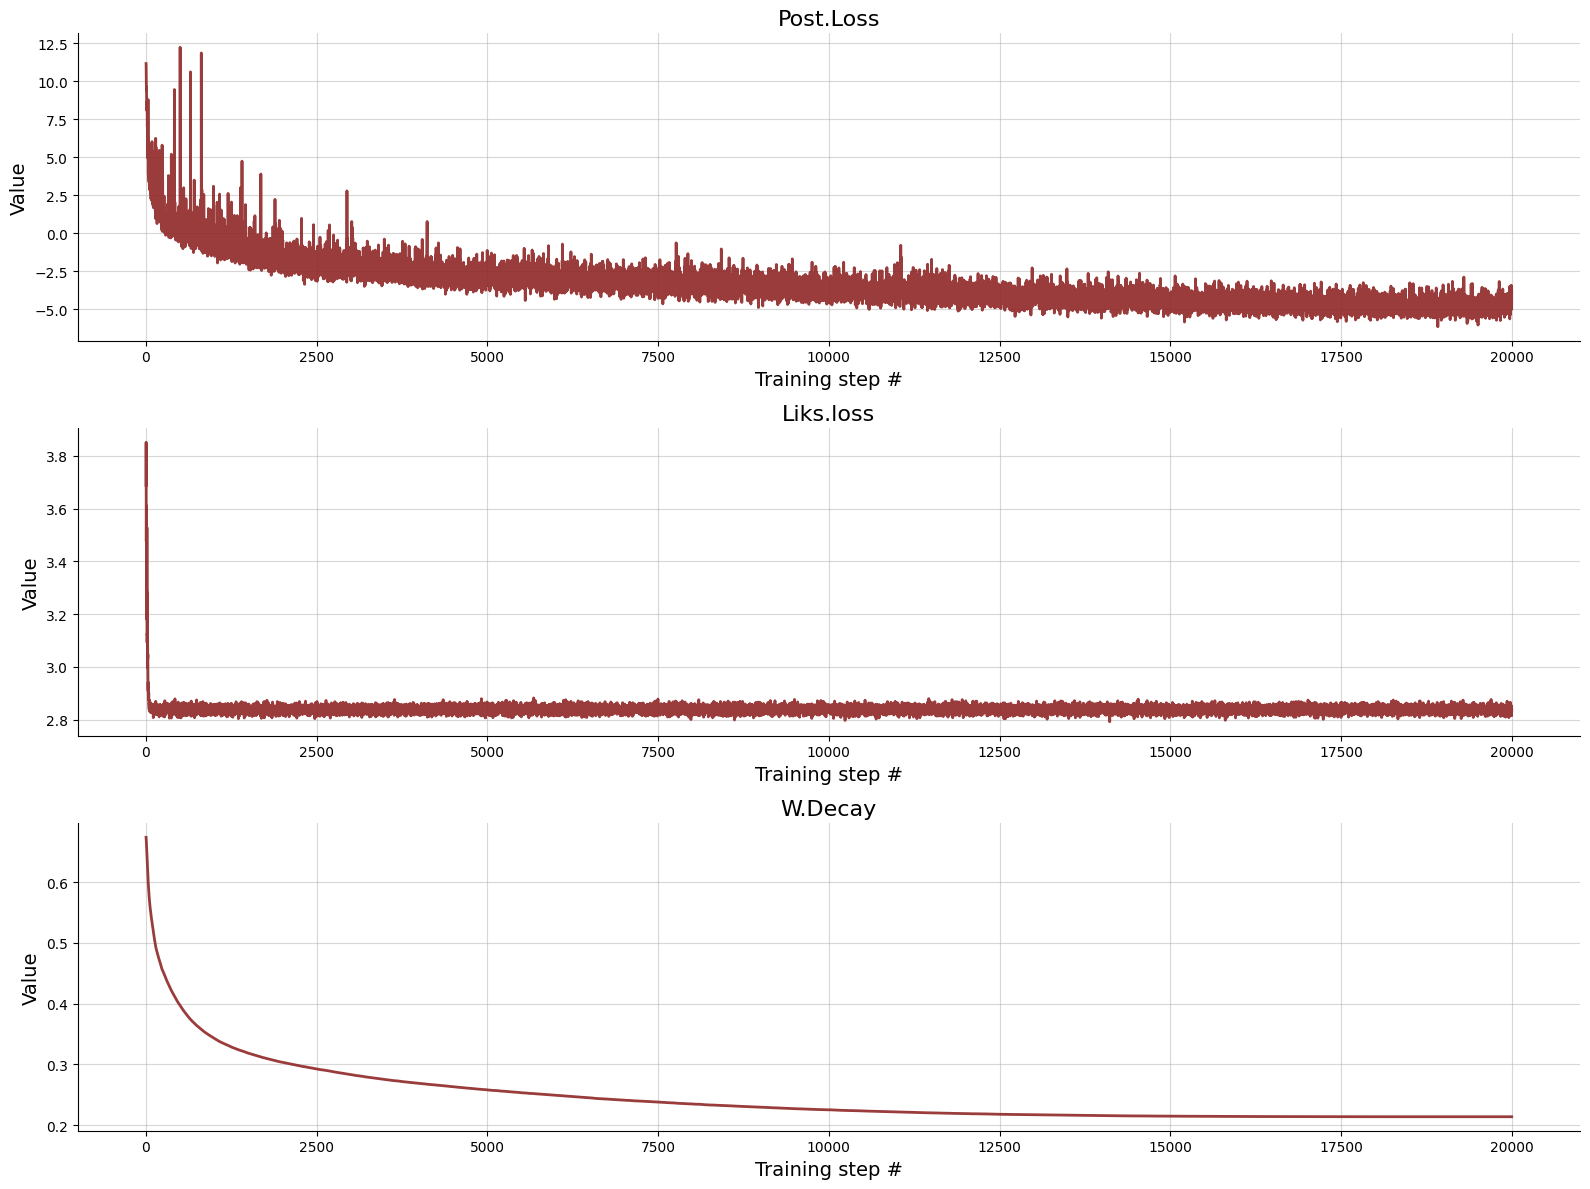

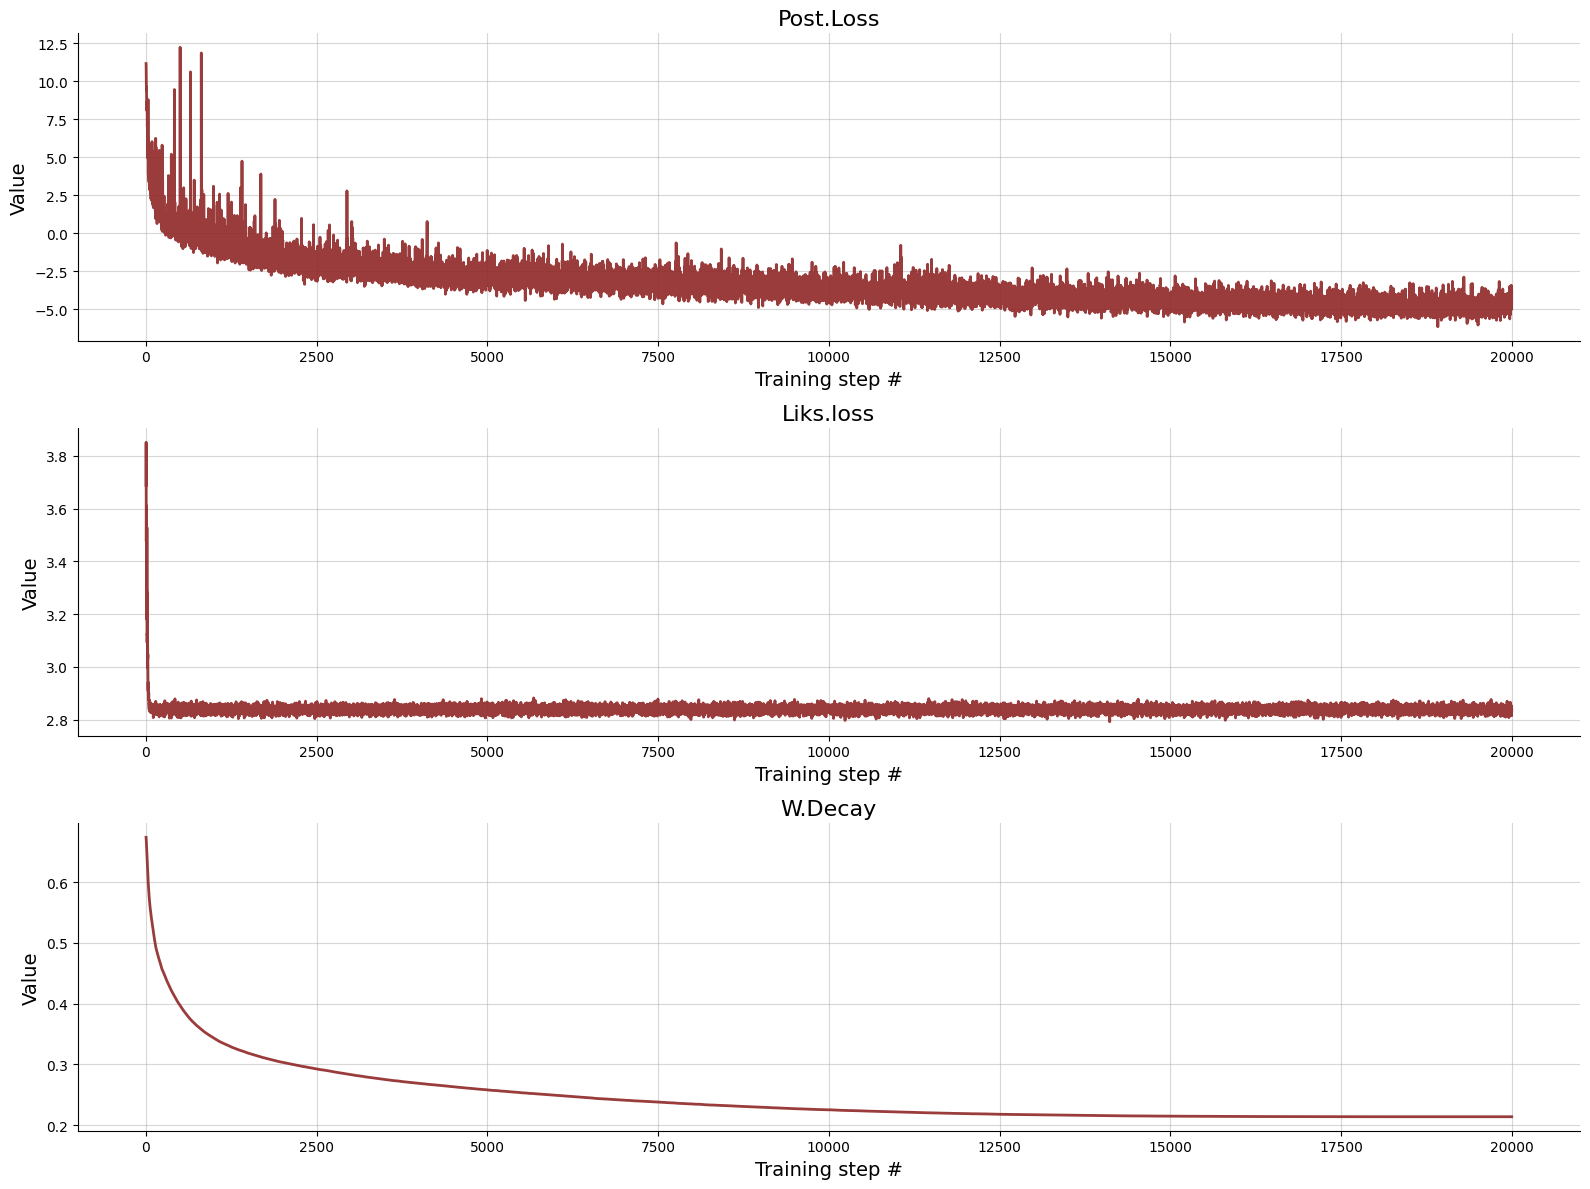

In [14]:
bf.diagnostics.plot_losses(h)

In [8]:
data = model(100)
conf_data = configurator(data)
(z, _), lik_out = amortizer(conf_data)

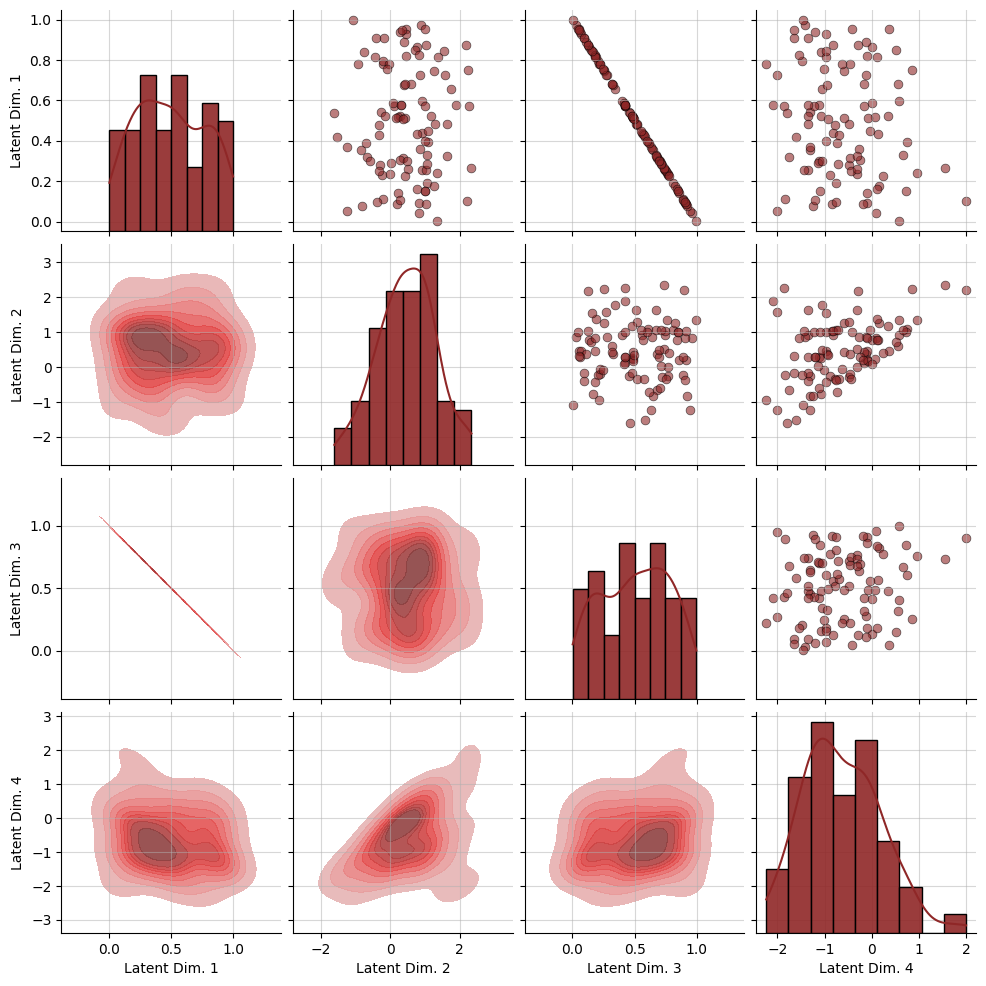

In [9]:
f = bf.diagnostics.plot_latent_space_2d(z)

In [9]:
samples = amortizer.sample(conf_data, n_post_samples=10, n_lik_samples=10)

In [16]:
conf_data['posterior_inputs']["parameters"].shape

(100, 4)